In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import string
import requests
import io
import nltk
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [17]:
sess = tf.Session()

batch_size = 200
max_features = 1000

In [18]:
save_file_name = 'temp_spam_data.csv'
if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # データの書式を設定
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    # CSVに書き込む
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

In [19]:
# 'spam' のラベルを 1, 'ham' のラベルを 0 に変更
target = [1. if x=='spam' else 0. for x in target]

In [20]:
# テキストを正規化します。
# 小文字に変換
texts = [x.lower() for x in texts]

# 句読点を削除
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# 数字を削除
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# 余分なホワイトスペースを削除
texts = [' '.join(x.split()) for x in texts]

In [21]:
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# テキストの TF-IDF を作成
nltk.download('all')
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', max_features=max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

[nltk_data]    |   Package timit is already up-to-date!
[nltk_data]    | Downloading package toolbox to /root/nltk_data...
[nltk_data]    |   Package toolbox is already up-to-date!
[nltk_data]    | Downloading package treebank to /root/nltk_data...
[nltk_data]    |   Package treebank is already up-to-date!
[nltk_data]    | Downloading package twitter_samples to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to /root/nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to /root/nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-date!
[nltk_data]    | Downloading package universal_treebanks_v20 to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Packa

In [22]:
train_indices = np.random.choice(sparse_tfidf_texts.shape[0], round(0.8*sparse_tfidf_texts.shape[0]), replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) - set(train_indices)))
texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

In [23]:
# ロジスティック回帰の変数を作成
A = tf.Variable(tf.random_normal(shape=[max_features,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# プレースホルダを初期化
x_data = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [24]:
# ロジスティックモデルを設定
model_output = tf.add(tf.matmul(x_data, A), b)

# 損失関数を設定
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

In [25]:
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [26]:
# 最適化関数を設定
my_opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_opt.minimize(loss)

# 変数を初期化
init = tf.global_variables_initializer()
sess.run(init)

In [27]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size=batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # 損失値と正解率を 100 回おきに記録
    if (i+1)%100==0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 500. Train Loss (Test Loss): 0.67 (0.77). Train Acc (Test Acc): 0.62 (0.55)
Generation # 1000. Train Loss (Test Loss): 0.64 (0.66). Train Acc (Test Acc): 0.65 (0.65)
Generation # 1500. Train Loss (Test Loss): 0.57 (0.60). Train Acc (Test Acc): 0.68 (0.70)
Generation # 2000. Train Loss (Test Loss): 0.53 (0.56). Train Acc (Test Acc): 0.78 (0.74)
Generation # 2500. Train Loss (Test Loss): 0.55 (0.53). Train Acc (Test Acc): 0.72 (0.77)
Generation # 3000. Train Loss (Test Loss): 0.55 (0.51). Train Acc (Test Acc): 0.77 (0.78)
Generation # 3500. Train Loss (Test Loss): 0.50 (0.50). Train Acc (Test Acc): 0.80 (0.79)
Generation # 4000. Train Loss (Test Loss): 0.56 (0.49). Train Acc (Test Acc): 0.78 (0.81)
Generation # 4500. Train Loss (Test Loss): 0.46 (0.48). Train Acc (Test Acc): 0.81 (0.82)
Generation # 5000. Train Loss (Test Loss): 0.51 (0.48). Train Acc (Test Acc): 0.80 (0.82)
Generation # 5500. Train Loss (Test Loss): 0.36 (0.47). Train Acc (Test Acc): 0.88 (0.82)
Generation 

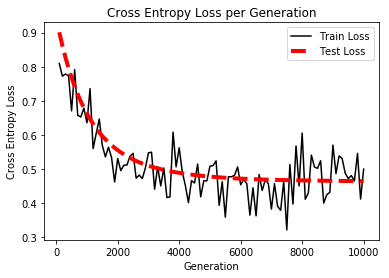

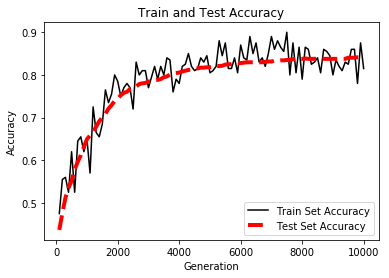

In [28]:
# 損失値をプロット
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# 正解率をプロット
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()